In [1]:
# gerekli importlar

import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
# veri seti
df = pd.read_excel("online_retail_II.xlsx", sheet_name="Year 2010-2011")

In [3]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55000,17850.00000,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39000,17850.00000,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75000,17850.00000,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39000,17850.00000,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39000,17850.00000,United Kingdom


In [4]:
df.shape

(541910, 8)

In [5]:
# null degerler
df.isnull().sum()

# Description'da 1454
# Customer ID'de 135080 eksik deger var.

Invoice             0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
Customer ID    135080
Country             0
dtype: int64

In [6]:
# eksik degerleri siliyoruz.
df.dropna(inplace= True)

In [7]:
# kontrol için tekrar bakalım eksik deger sayısına
df.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

In [8]:
# fatura numarası C ile baslayan iadeleri cıkarıyoruz.
df = df[~df["Invoice"].str.contains("C", na=False)]

In [9]:
# aykırı degerleri belirliyoruz
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.05)
    quartile3 = dataframe[variable].quantile(0.95)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

# aykırı degerleri limitlere baskılıyoruz.
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [10]:
# quantity ve price değişkenleri için aykırı degerleri baskılıyoruz.
replace_with_thresholds(df, "Quantity")
replace_with_thresholds(df, "Price")

In [11]:
# fatura başına elde edilen toplam kazanç
df["TotalPrice"] = df["Quantity"] * df["Price"]

In [12]:
# RFM metriklerinin hesaplanması:
# analizi hangi tarihe göre yapmak istiyorsak o tarihi belirliyoruz.
today_date = dt.datetime(2011, 12, 11)

In [13]:
# her müşteriye ait degerler
rfm = df.groupby('Customer ID').agg({'InvoiceDate': lambda InvoiceDate: (today_date - InvoiceDate.max()).days,
                                     'Invoice': lambda Invoice: Invoice.nunique(),
                                     'TotalPrice': lambda TotalPrice: TotalPrice.sum()})

In [14]:
# olustutulan metriklerin isimlerini değiştiriyoruz
rfm.columns = ['Recency', 'Frequency', 'Monetary']

In [15]:
rfm.head()

,Recency,Frequency,Monetary
Customer ID,,,
12346.00000,326,1,92.04000
12347.00000,3,7,4152.44000
12348.00000,76,4,1415.20500
12349.00000,19,1,1458.84000
12350.00000,311,1,315.02000


In [16]:
# monetary degeri 0 dan büyük olacak sekilde filtrelendirme yapıyoruz.
rfm = rfm[rfm['Monetary'] > 0]

In [17]:
# RFM metriklerini skorlara ceviriyourz.
# recency degerinde bir farklılık vardı, en yeni ziyaret edenler daha yüksek skor almalı bu sebeple en kücük recency degerine sahipler en yüksek skoru alır.
rfm['recency_score'] = pd.qcut(rfm['Recency'], 5, [5, 4, 3, 2, 1])
rfm['frequency_score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, [1, 2, 3, 4, 5])  
rfm['monetary_score'] = pd.qcut(rfm['Monetary'], 5, [1, 2, 3, 4, 5]) 

In [18]:
# metriklerin skorlarını birleştiriyoruz.
# monetary metrigini hesaba katmıyoruz.
rfm['RFM_SCORE'] = (rfm['recency_score'].astype('str') + rfm['frequency_score'].astype('str'))

In [19]:
rfm.head()

,Recency,Frequency,Monetary,recency_score,frequency_score,monetary_score,RFM_SCORE
Customer ID,,,,,,,
12346.00000,326,1,92.04000,1,1,1,11
12347.00000,3,7,4152.44000,5,5,5,55
12348.00000,76,4,1415.20500,2,4,4,24
12349.00000,19,1,1458.84000,4,1,4,41
12350.00000,311,1,315.02000,1,1,2,11


In [20]:
# skor segmentleri
seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_Risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}

In [21]:
# skorları segmentlere göre sınıflıyoruz
rfm['segment'] = rfm['RFM_SCORE'].replace(seg_map, regex=True)

In [22]:
rfm.head()

,Recency,Frequency,Monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,segment
Customer ID,,,,,,,,
12346.00000,326,1,92.04000,1,1,1,11,hibernating
12347.00000,3,7,4152.44000,5,5,5,55,champions
12348.00000,76,4,1415.20500,2,4,4,24,at_Risk
12349.00000,19,1,1458.84000,4,1,4,41,promising
12350.00000,311,1,315.02000,1,1,2,11,hibernating


In [23]:
# K-MEANS

In [24]:
pd.set_option('display.width', 500)
pd.set_option('display.expand_frame_repr', False)

In [25]:
selected = rfm[['Recency', 'Frequency']]
selected.head()

,Recency,Frequency
Customer ID,,
12346.00000,326,1
12347.00000,3,7
12348.00000,76,4
12349.00000,19,1
12350.00000,311,1


In [26]:
#  recency ve frequency için standartlastırma yapıyoruz
sc = MinMaxScaler()
sc.fit(selected)

MinMaxScaler()

In [27]:
scaled = sc.transform(selected) # scaled =  metriklerin standartlastırılmıs hali.
# yeni bir df olusturuyoruz standartlastırılmıs recency ve frequency degerlerini gösteren:
scaled_df = pd.DataFrame(scaled, columns=selected.columns,index=selected.index) 
scaled_df.head()

,Recency,Frequency
Customer ID,,
12346.00000,0.87131,0.00000
12347.00000,0.00536,0.02871
12348.00000,0.20107,0.01435
12349.00000,0.04826,0.00000
12350.00000,0.83110,0.00000


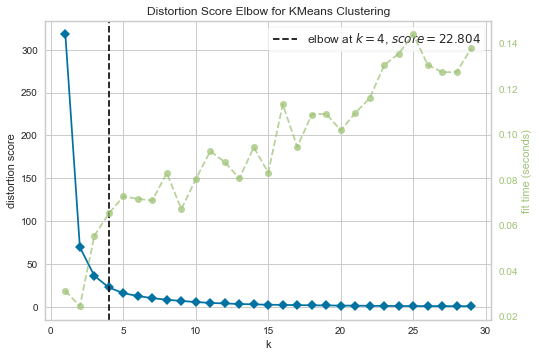

4

In [28]:
# optimum küme sayısını elbow yöntemi ile bulmak:

kmeans = KMeans(random_state=17)
ssd = []
K = range(1,30)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=17).fit(scaled_df)
    ssd.append(kmeans.inertia_)

kmeans = KMeans()
elbow = KElbowVisualizer(kmeans, k=(1, 30))
elbow.fit(scaled_df)
elbow.show()
elbow.elbow_value_ 

# elbow yöntemi optimum kume sayısını 4 olarak buldu.

In [29]:
# Final Cluster'ların Oluşturulması: (bulunan optimum kume sayısına göre)
kmeans = KMeans(n_clusters=elbow.elbow_value_ , random_state=17).fit(scaled_df)
kumeler = kmeans.labels_

In [30]:
# kumeleri verisetine ekliyoruz.
rfm["cluster_no"] = kumeler
rfm["cluster_no"] = rfm["cluster_no"] + 1 # 0'dan baslamaması için

In [31]:
rfm.head()

,Recency,Frequency,Monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,segment,cluster_no
Customer ID,,,,,,,,,
12346.00000,326,1,92.04000,1,1,1,11,hibernating,3
12347.00000,3,7,4152.44000,5,5,5,55,champions,1
12348.00000,76,4,1415.20500,2,4,4,24,at_Risk,4
12349.00000,19,1,1458.84000,4,1,4,41,promising,1
12350.00000,311,1,315.02000,1,1,2,11,hibernating,3


In [32]:
# k-means yöntemi ile olusturulan kumelerde kacar kişi var?
rfm.groupby("cluster_no").agg({"cluster_no": "count"})

,cluster_no
cluster_no,
1,2210
2,598
3,497
4,1033
